In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
sns.set_palette("husl")

# Time Series data with single variable

## Simulated data generation

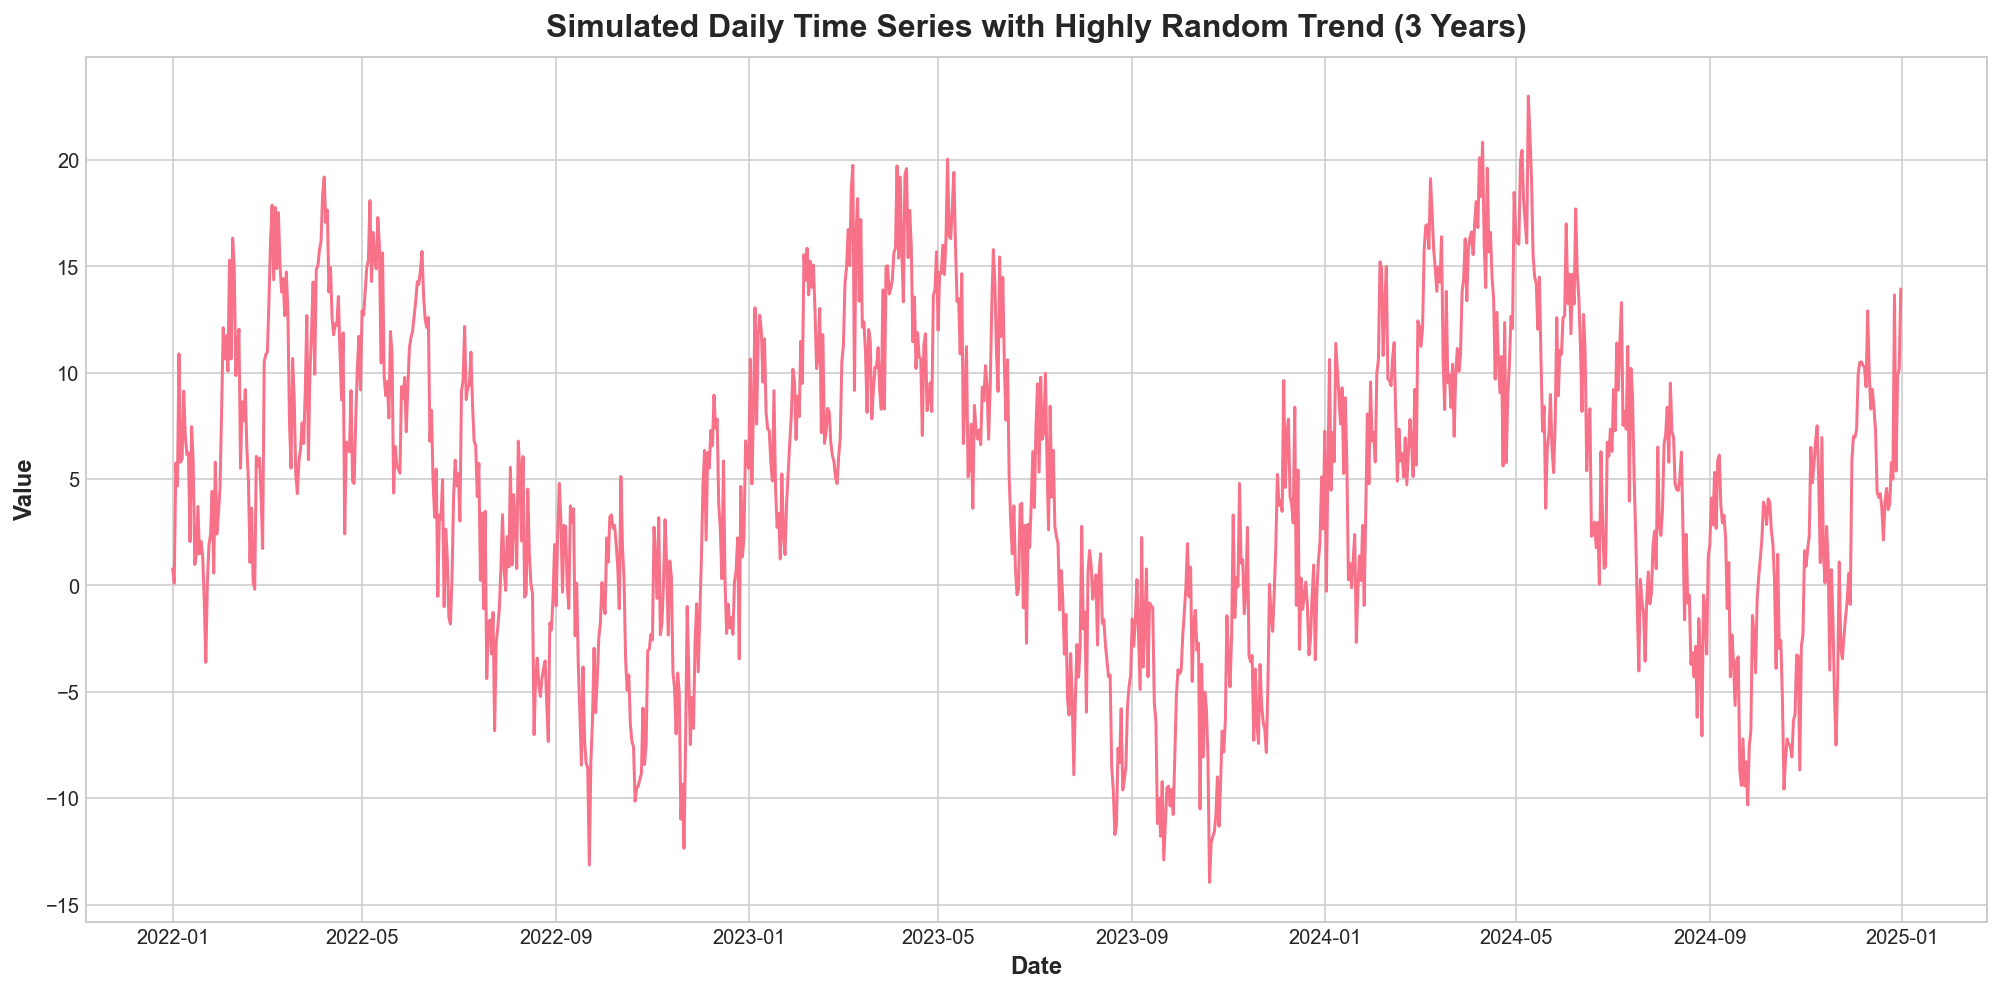

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create the date range for the simulated data
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
# higher loc may result in increasing trend
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

# based on the sin method to create a smooth trend for the seasonality
yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)

# create the noise with antoher scale 
noise = np.random.normal(loc=0, scale=2, size=len(dates))

# add up the trend, seasonality and noise for the data
data = trend + yearly_seasonality + monthly_seasonality + noise

# convert it into a dataframe with the date and values columns
time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

# simplementation time series chart to display the data generated
plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Time Series Analyzer

In [3]:
notebook_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to the Python path")
    
from time_series_data_nature_discovery import TimeSeriesAnalyzer

Added '/Users/dctmh/Python Code/stat_test' to the Python path


In [4]:
# instance creation
time_series_ssd = TimeSeriesAnalyzer(time_series, date_column = 'date', value_column = 'values')

### Basic statistics on the time series data

In [5]:
# simple statistics
time_series_ssd.basic_statistics()

=== BASIC STATISTICS ===
Period: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total observations: 1096
Mean: 4.7031
Std: 7.3776
Min: -13.9521
Max: 23.0057
Missing values: 0


### Simple data visualization

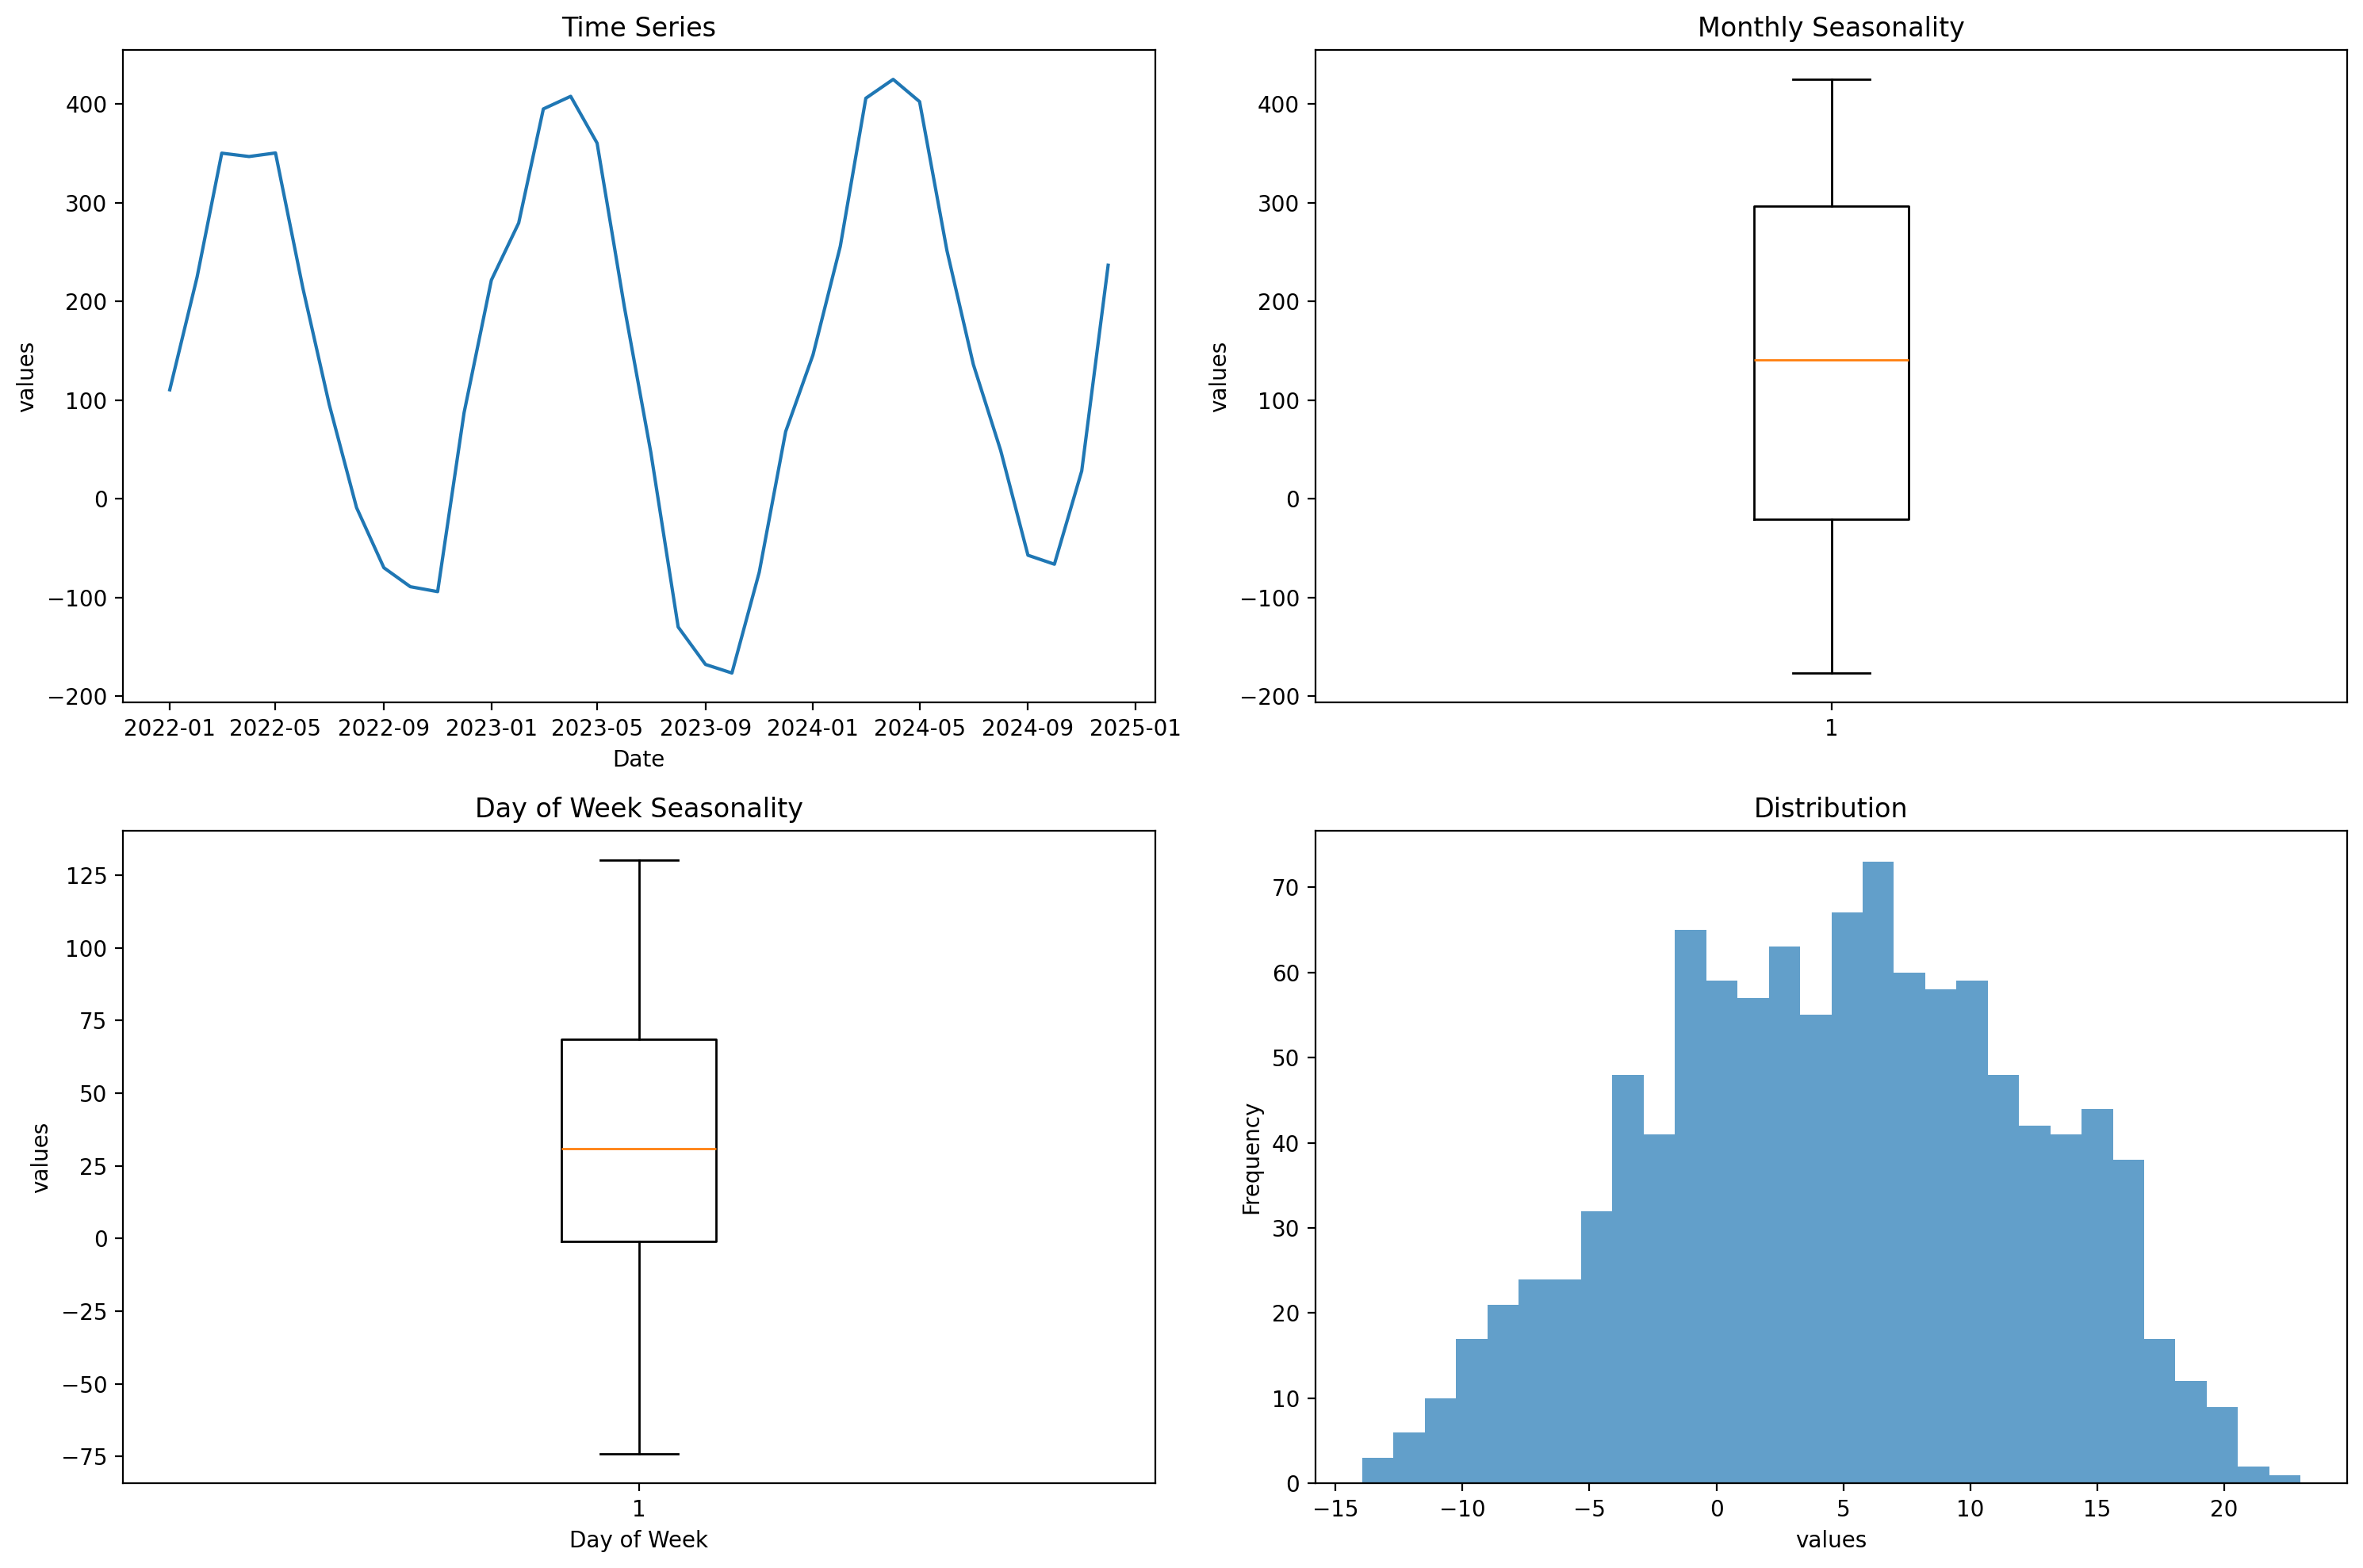

In [6]:
# look into the trend, monthly, daily outliers and the data distributions
time_series_ssd.visual_inspection()

### Auto-correlation (ACF & PACF)

- ACF: Properly check the stability or if there's any exponential decay, all lags are in the confidence interval -> White noise.

- PACF: Detect the order of auto-regressions, pay attention to the lag out of the confidence interval, those lags within the interval assuming there's no effect.


=== AUTOCORRELATION ANALYSIS ===


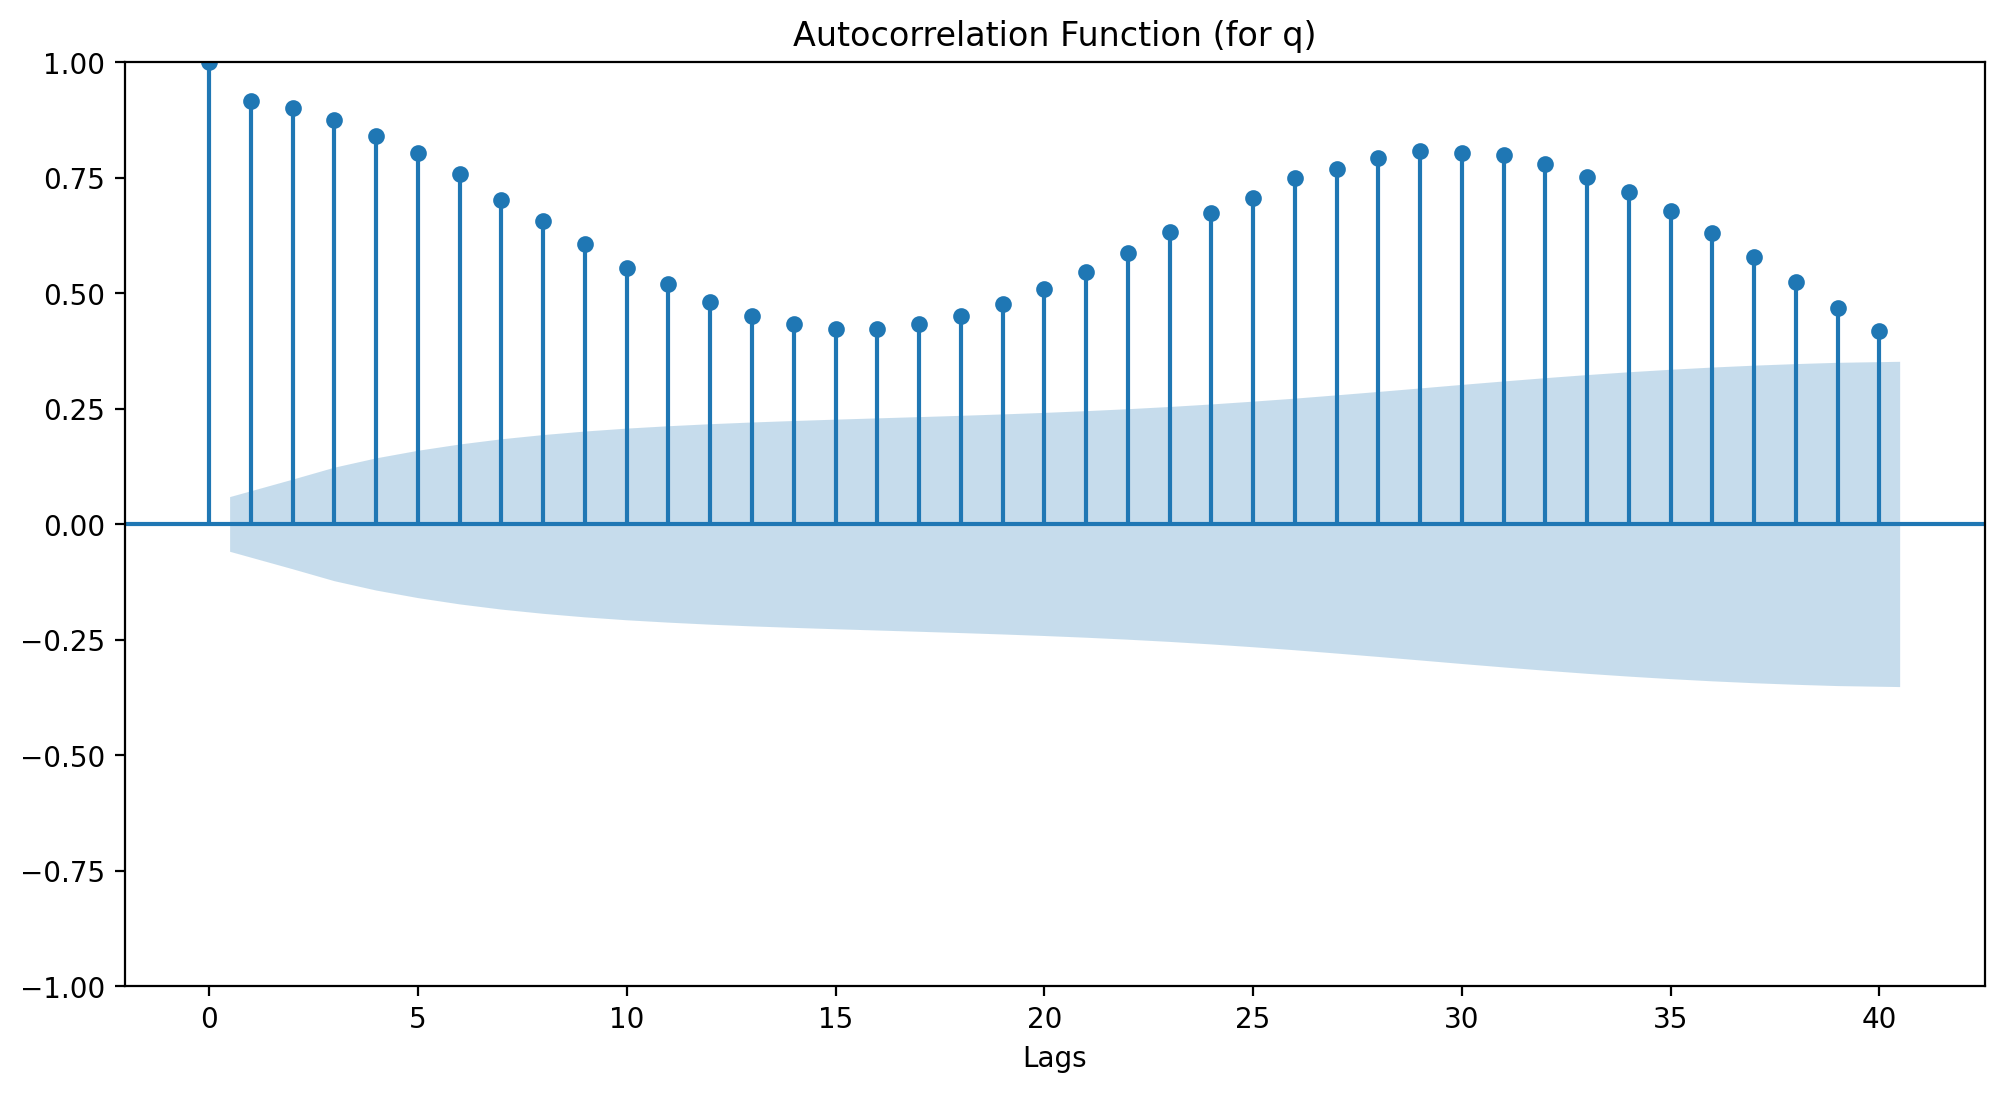

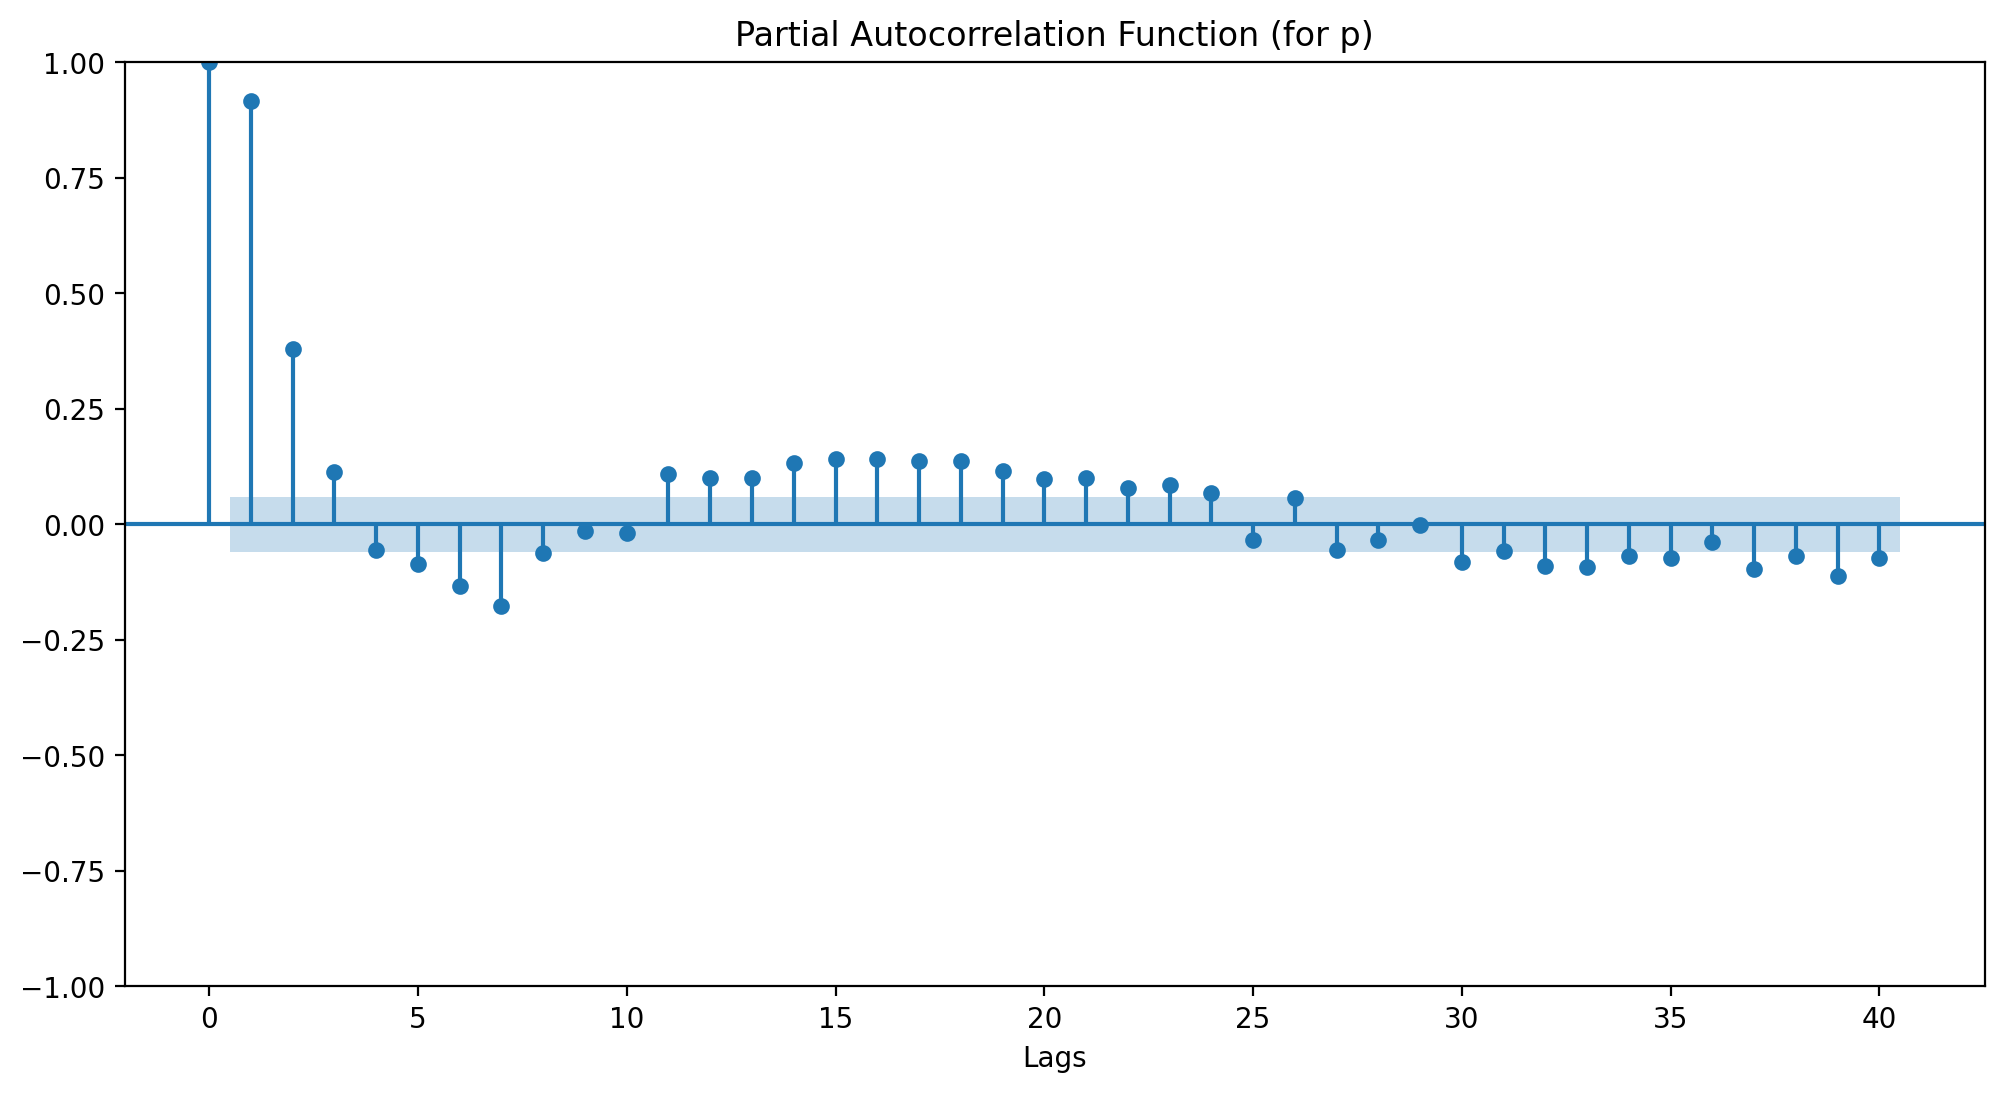


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.7042
Lag 30 autocorrelation: 0.8114
Lag 90 autocorrelation: 0.2379
Lag 180 autocorrelation: -0.4744
Lag 365 autocorrelation: 0.8698


In [7]:
# do the daily autocorrelation and see if previous days got an effect on the upcoming days
time_series_ssd.autocorrelation_analysis('daily')

## Day of week pattern

Based on the average to check if the some of the day of week may impact the target values. Therefore, it may help to plan say for the budget allocation and the weight across the week.

F-test is also applied to determine if there's any significant week of day effect.

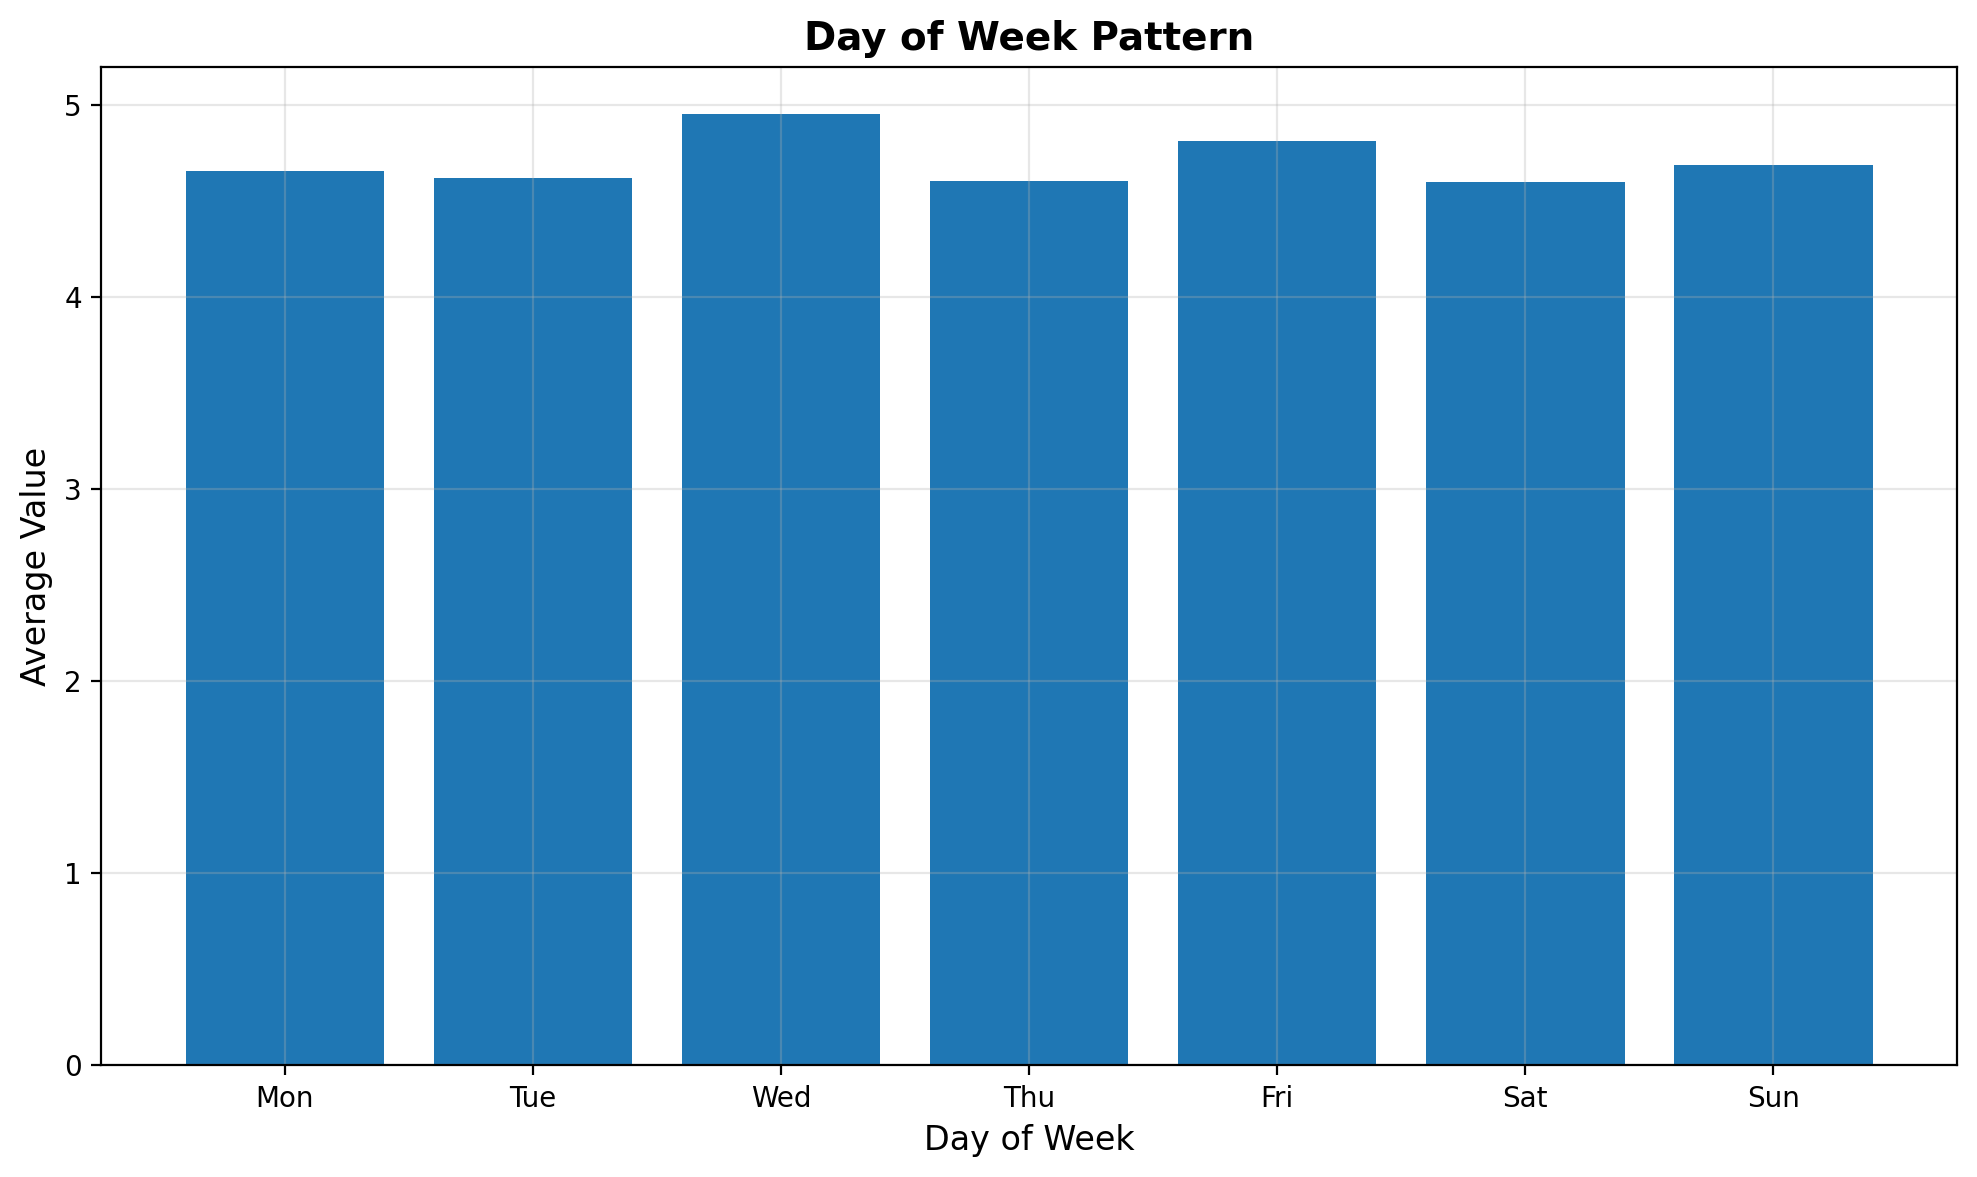


Day-of-Week Effect:
F-statistic: 0.0496, p-value: 0.9995
No significant day-of-week effect


In [8]:
time_series_ssd.day_of_week_pattern()

## Monthly Pattern

Similarly, this test checks whether any month carries significantly more weight compared to the yearly average. 

An F-test is also used to determine if a strong monthly effect is present.


Monthly Effect:
F-statistic: 170.5552, p-value: 0.0000
✓ Significant monthly effect detected!


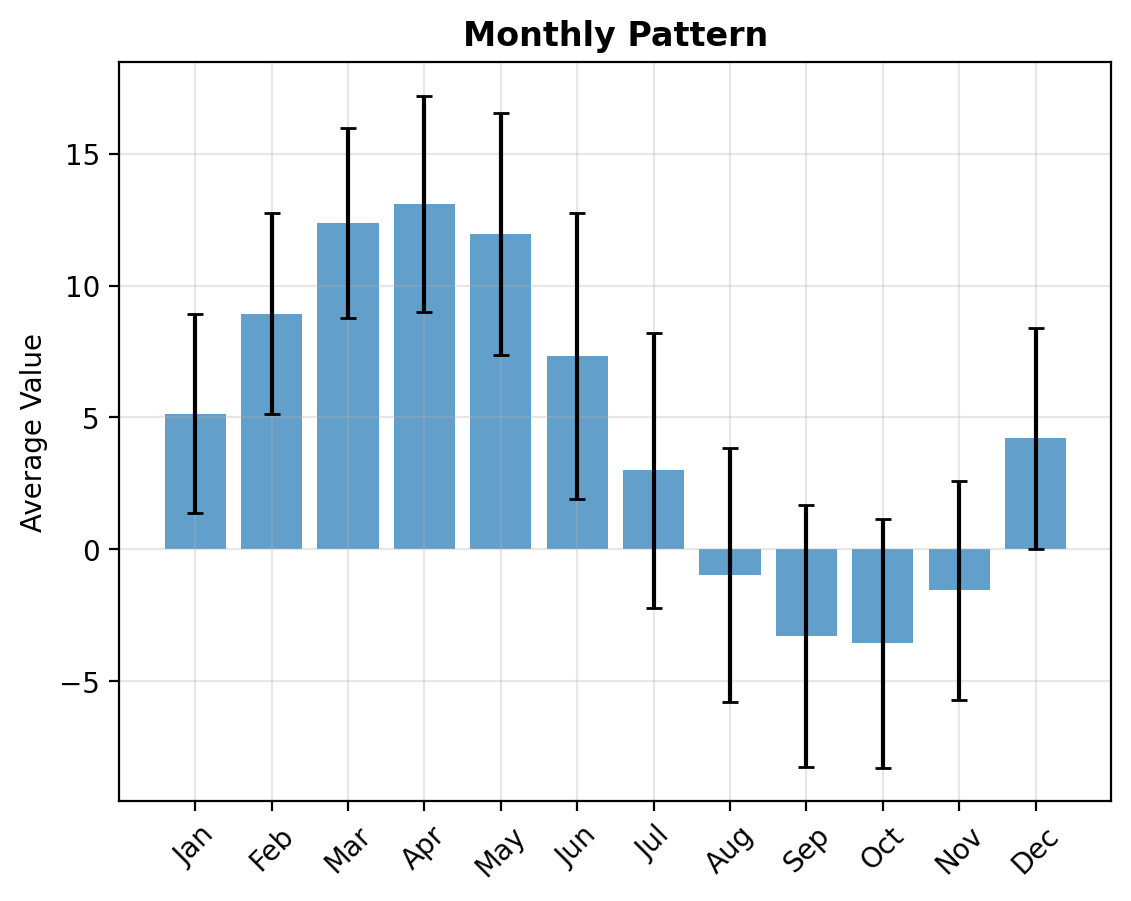

In [9]:
time_series_ssd.month_pattern()

## Week of year pattern

Similarly, this test checks whether any week out of the 52 weeks in a year carries significantly more weight compared to the yearly average.

Additionally, a one-way F-test (ANOVA) is used to determine whether a strong week-of-year effect is present.

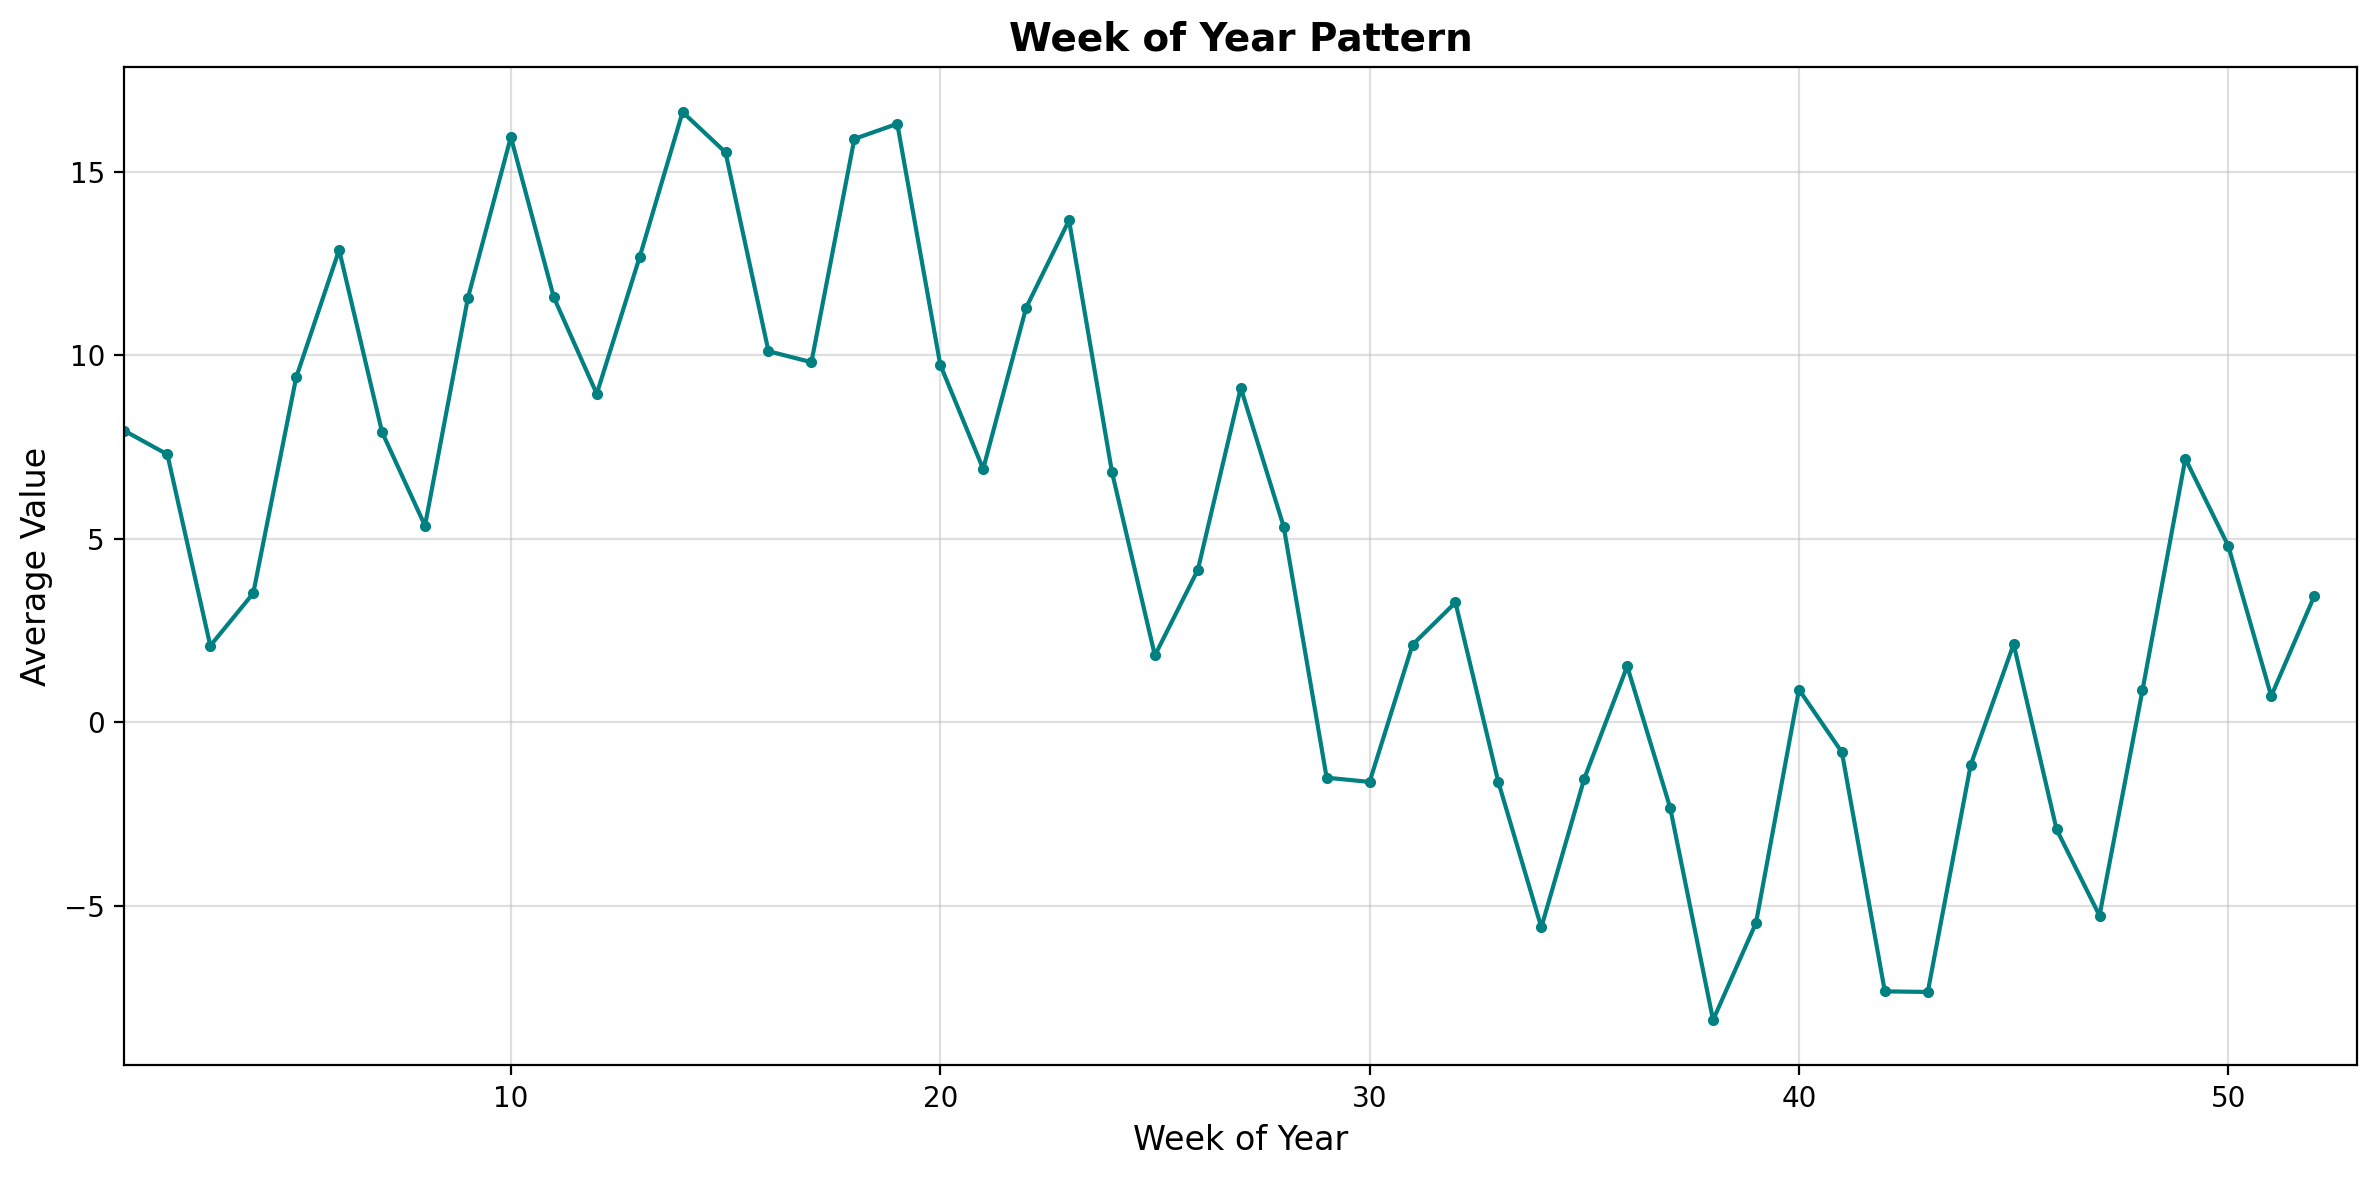


Week-of-Year Effect (ANOVA Test):
F-statistic: 101.5251, p-value: 0.0000
Significant week-of-year pattern detected!


In [10]:
time_series_ssd.week_of_year_pattern()

## Frequency domain analysis

This test is designed to check if any patterns can be found. In the example below, we can see a sharp peak at around 30 days. This indicates that a similar pattern was identified for approximately 30 days.


Frequency Analysis:
Dominant periods (days): [  30.44444444  274.          365.33333333  548.         1096.        ]


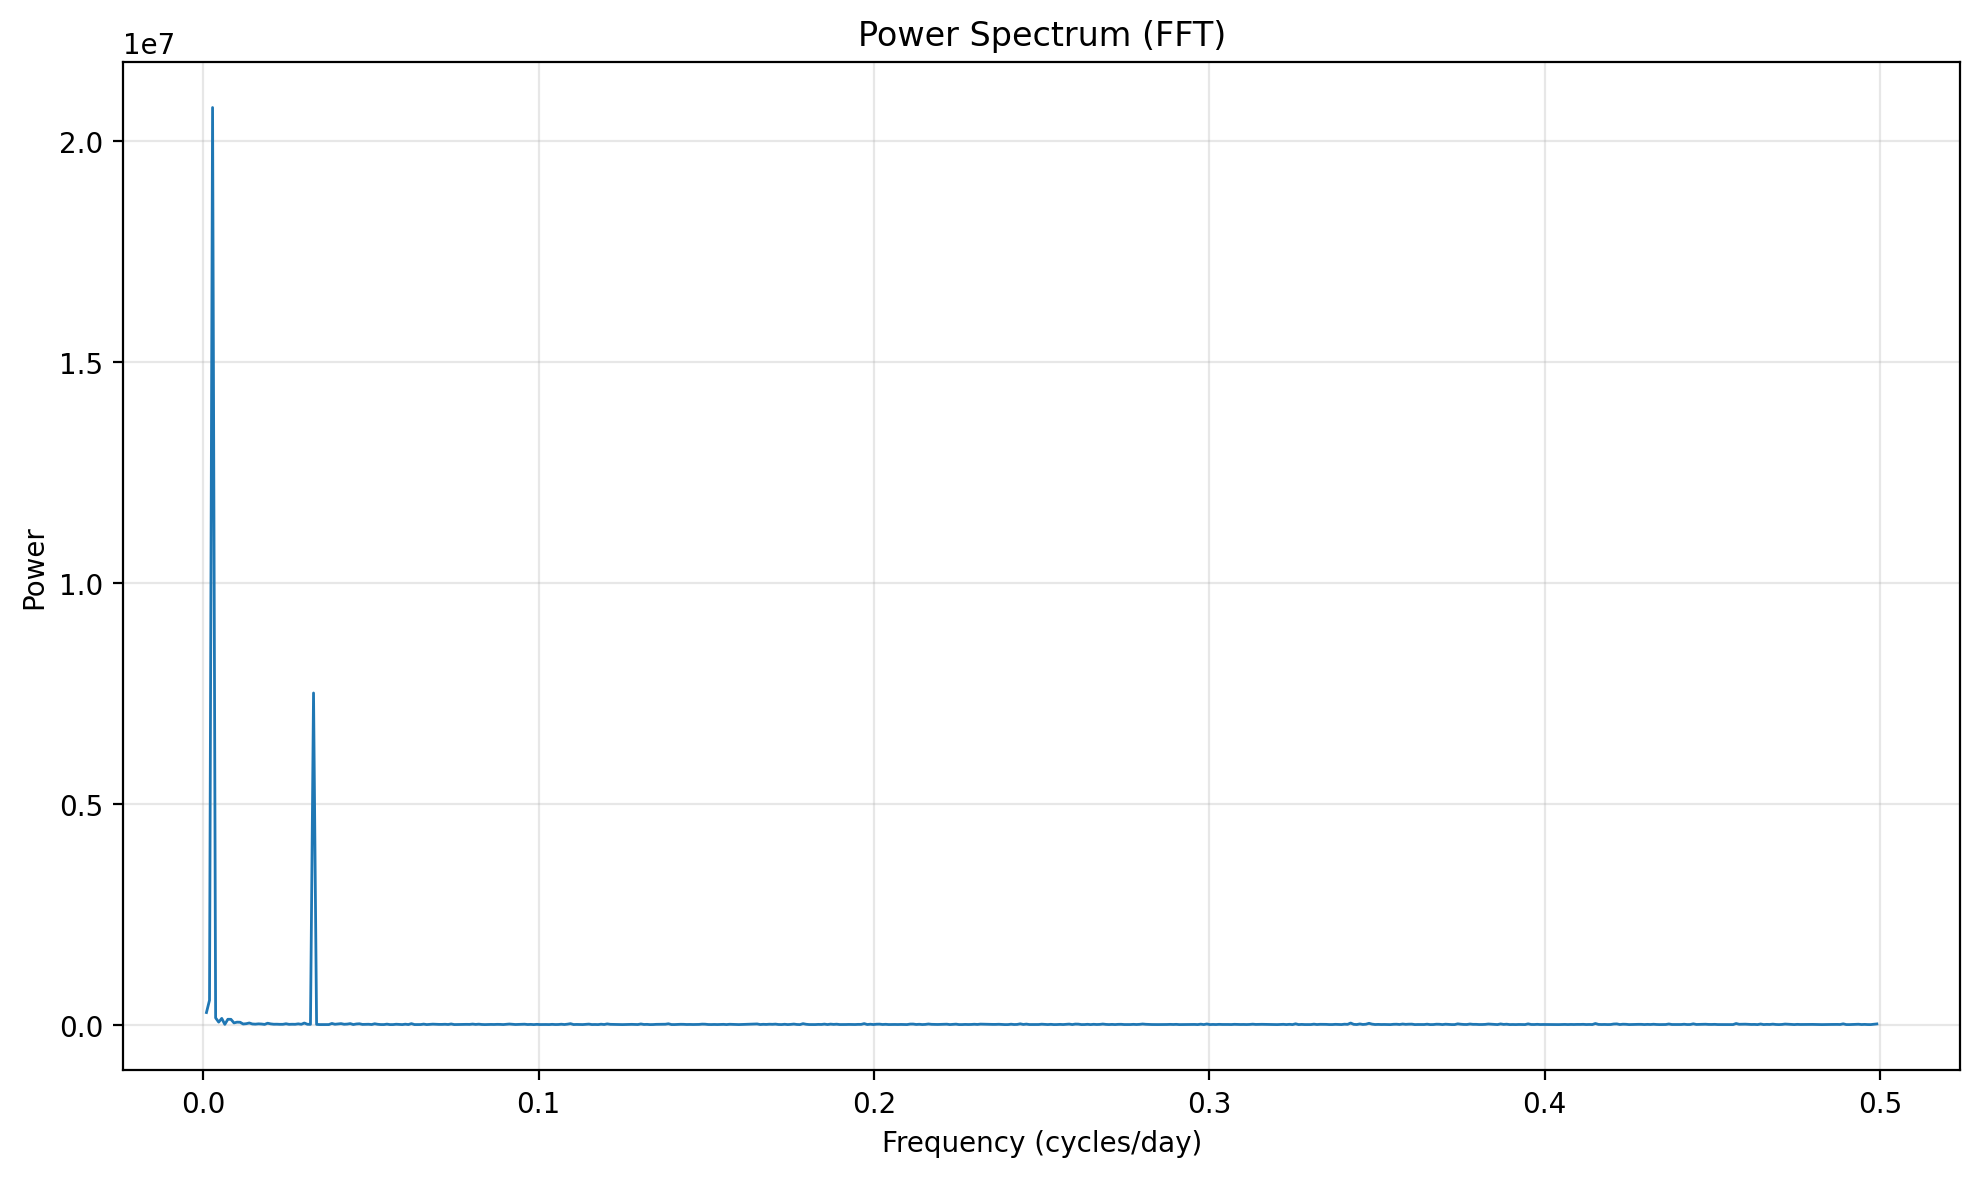

In [11]:
time_series_ssd.frequency_domain_analysis()

## ADF & Ljung-Box Test

### ADF test

The ADF test is used to check whether the time series is stationary. If the test rejects the null hypothesis, it means the series is stationary, making it suitable for use with the ARIMA model.

In [12]:
time_series_ssd.stationary_test_adf(time_series_ssd.ts)

ADF Test (Stationarity):
  ADF Statistic: -1.1430
  p-value: 0.6976
  Critical Values: {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}
  Result: Series is non-stationary


### Ljung-Box Test

The Ljung-Box test is used to assess whether the residuals from the model are random. This test should be applied after building the ARIMA model. If your model is good, the Ljung-Box test should not be rejected, indicating that the residuals are randomly distributed and that all non-random information (such as trend, seasonality, and autocorrelation) has been successfully explained by the model.

In [13]:
time_series_ssd.autocorrelation_Ljung_box(time_series_ssd.ts)

Ljung-Box test failed


## Trend analysis on time series based on the moving average trend

Using the trend identified by a moving average, we will generate deterministic polynomial features. These features will then be used to fit the data and produce a simple forecast.

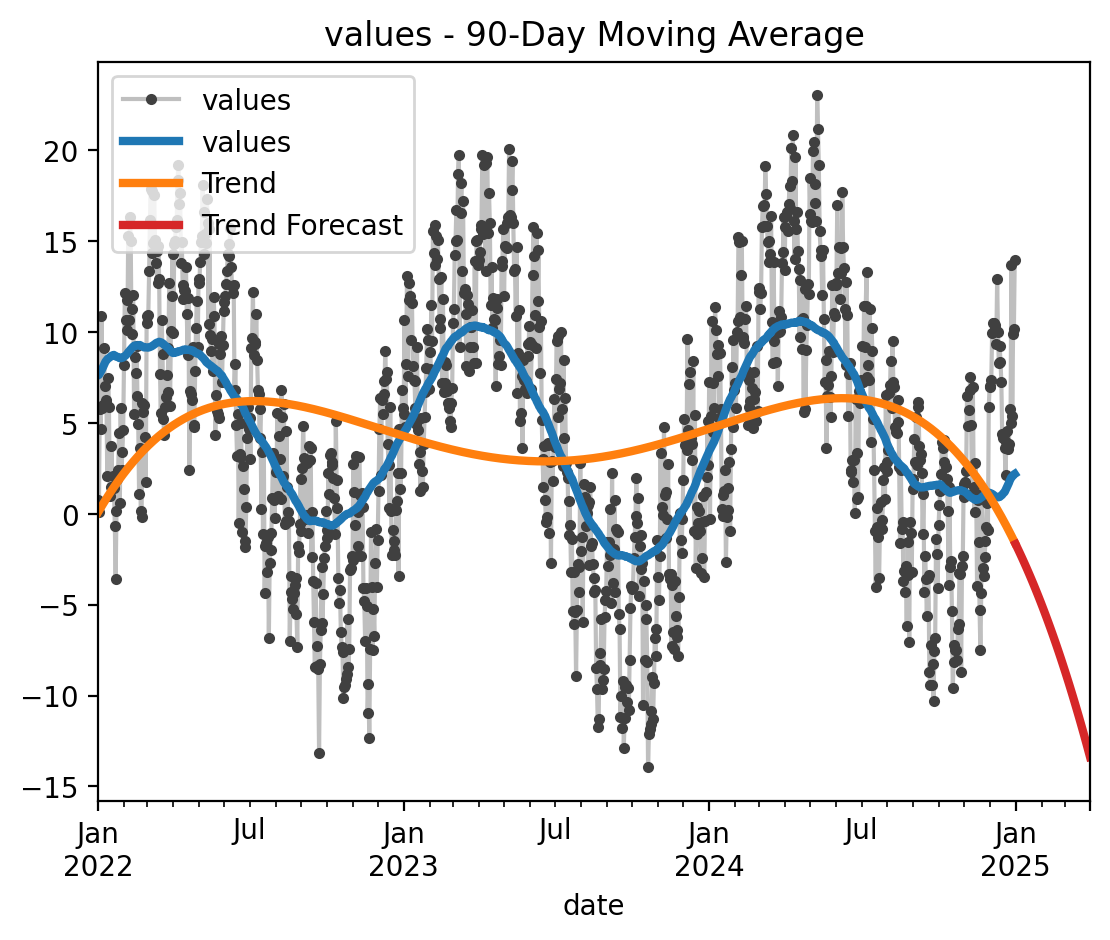

In [14]:
time_series_ssd.trend_analysis(180,4)

In [15]:
#TODO: Error detect for picking the best closing polynomial order

## Seasonality

### Seasonal plot

Idea are from Kaggle & https://stackoverflow.com/a/49238256/5769929 (Annotation point)

Try to investigate the season pattern based on the segments on some common period.
The period will be the 'season' you want to observe

#### Week in year vs day in week

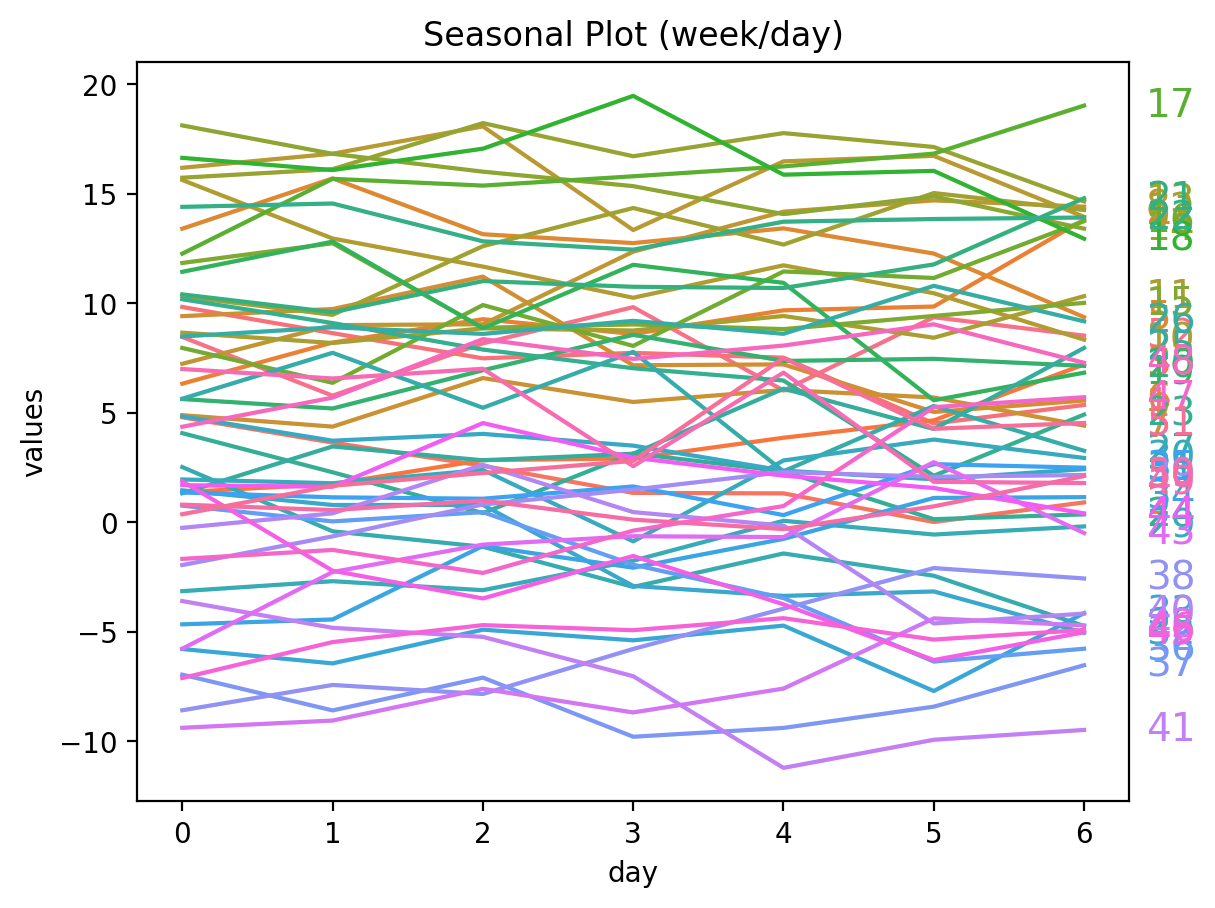

In [16]:
time_series_ssd.seasonal_plot();

#### day of year vs year

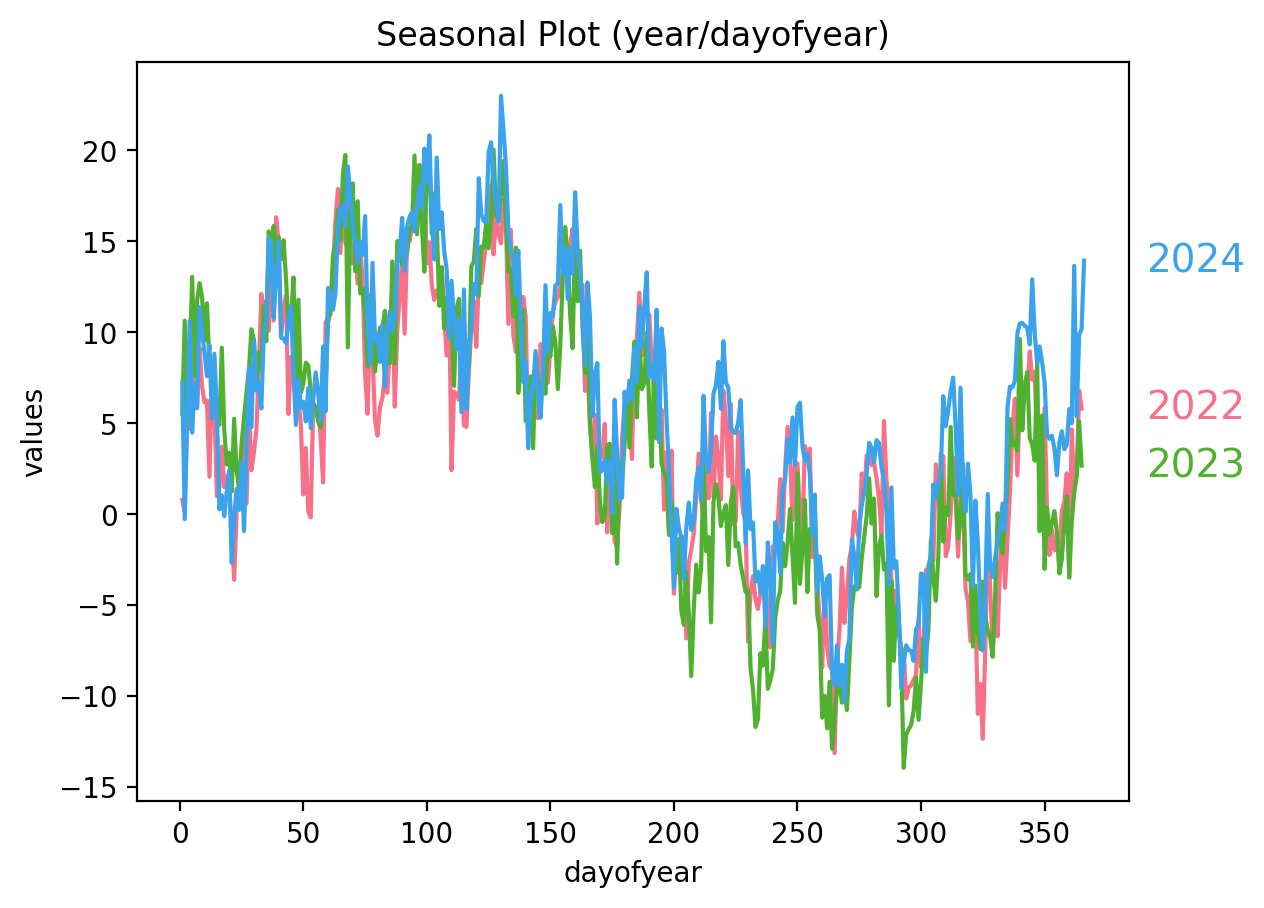

In [17]:
time_series_ssd.seasonal_plot(period = 'year', freq = 'dayofyear');

In [18]:
### Seasonal indicator

## Fourier Features

Suit for long seasons over many observations where indicator would be impractical. Instead of creating the feature for each date, fourier features used to capture overall shape of the seasonal curve into few features.

Fourier features are pairs of sine and cosine curves, one pair or each potential frequency in the season starting with the longest. Frequencies can be captured will be once per year, twice per year and three times per year etc.

If we add these set of sine and cosine curves to the training data, the linear regression will figure out the weights that's fit the seasonal component.
Only eight features will be needed (4 sine/ cosine pairs) to get a good estimate of the annual seasonality.

By mainly getting the main effect of seasonality with Fourier features, you'll usually need to add fewer features to your training data to prevent the overfitting & reduce computational time.

### Periodogram

Help to answer the number of fourier pairs included in the feature set.

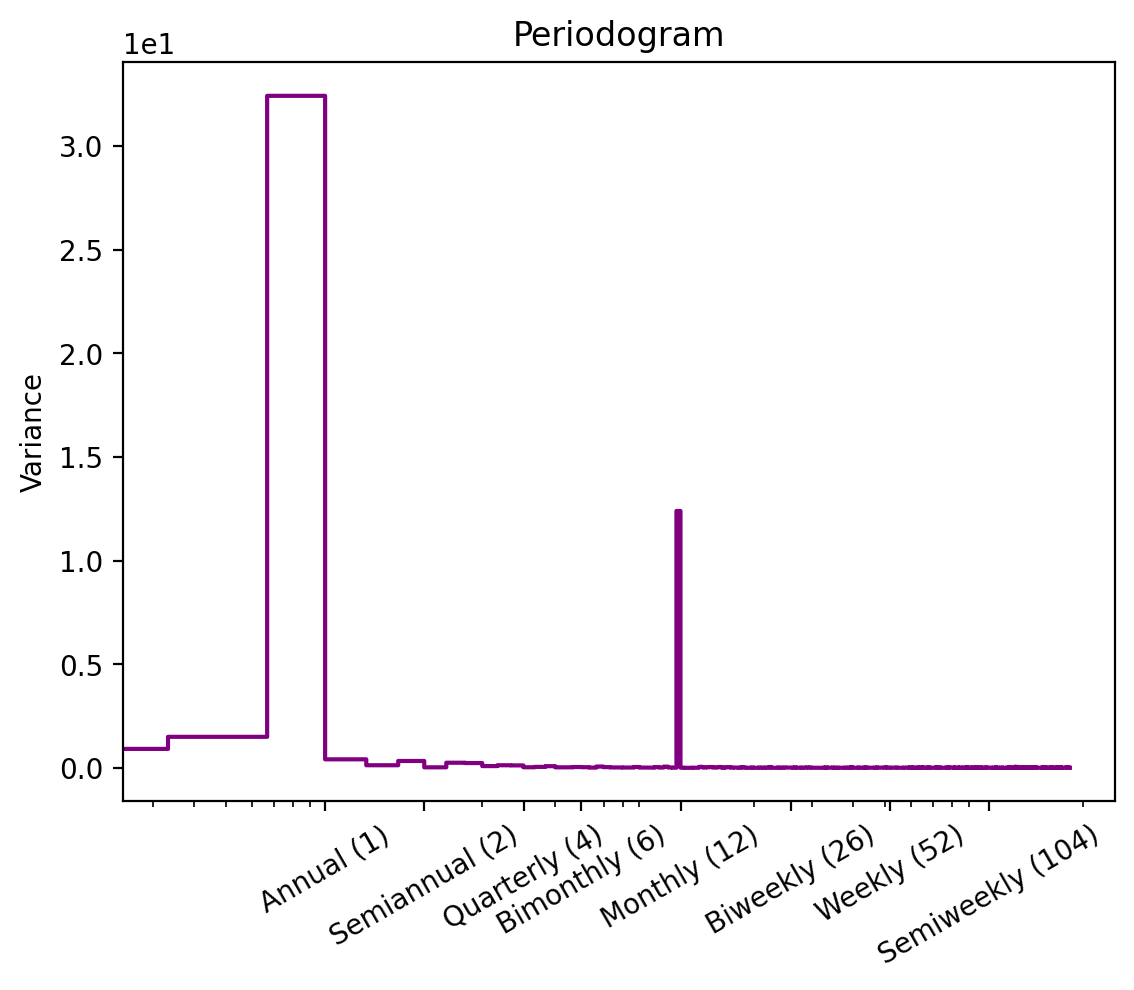

In [19]:
time_series_ssd.plot_periodogram();

Capture the fourier feature and ready for the forecast part.

Strong annual season was detected & we can try to use order = 1 which means 1 fourier pair for capturing the pattern.

In [20]:
X, _ = time_series_ssd.fourier_features_capture(order = 1)

In [21]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)"
date,,,,,,,,,,
2022-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2022-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852
2022-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407
2022-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667
2022-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,1.0,1092.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.085731,0.996318
2024-12-28,1.0,1093.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.068615,0.997643
2024-12-29,1.0,1094.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.051479,0.998674


Please check the forecast part in the time series forecast notebook.

### Seasonal decomposition

Default period will be 365 days to check on the trend, seasonal and the noise from the data.

I think it's not easy to get anything from the seasonal part. May be it's good to find some real sales data to check with the seanoality pattern for better observations.


=== SEASONAL DECOMPOSITION (Period: 365) ===


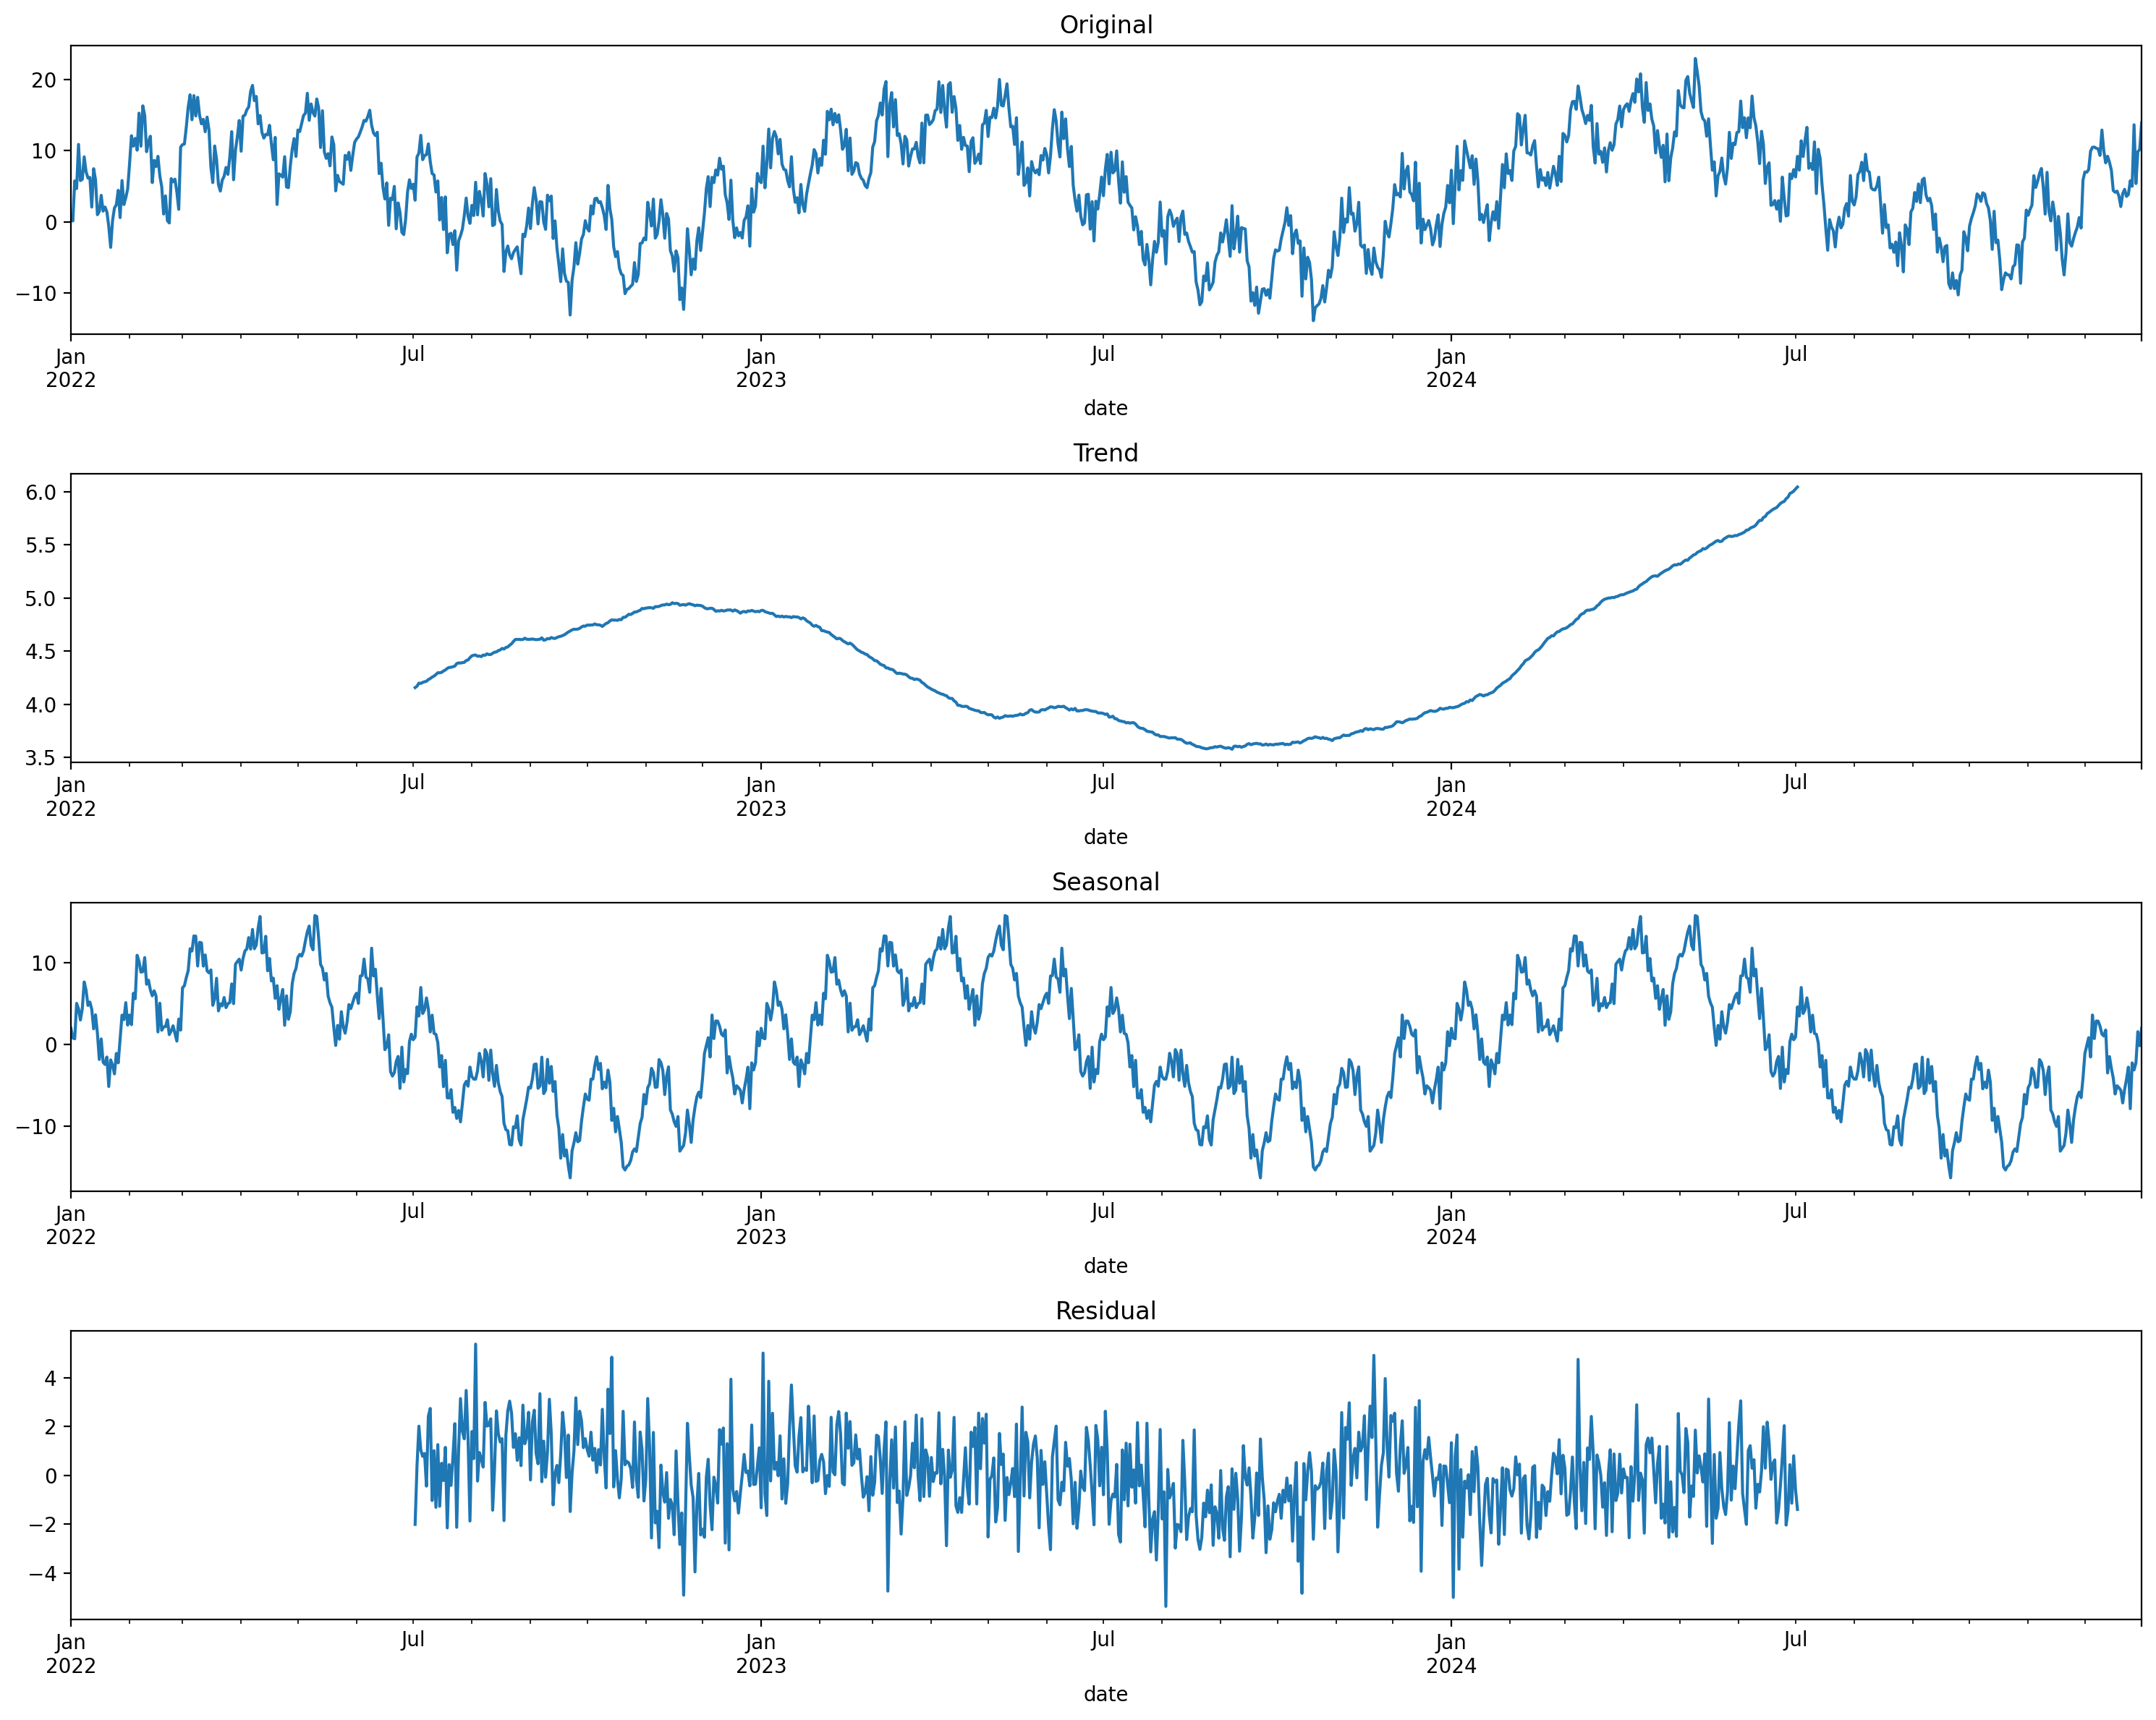

Seasonal Strength: 0.9558


In [22]:
# try to break down the data and see if there's any trend and season impact
# moving average & LOESS was used to get the trend
time_series_ssd.seasonal_decomposition()